In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Remote inference in Beam

The prefered way of running inference in Beam is by using the [RunInference API](https://beam.apache.org/documentation/sdks/python-machine-learning/). The RunInference API enables you to run your models as part of your pipeline in a way that is optimized for machine learning inference. It supports features such as batching, so that you do not need to take care of it yourself. For more info on the RunInference API you can check out the [RunInference notebook](https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_pytorch_tensorflow_sklearn.ipynb), which demonstrates how you can implement model inference in pytorch, scikit-learn and tensorflow.

As of now, RunInference API doesn't support making remote inference calls (e.g. Natural Language API, Cloud Vision API and others). Therefore, in order to use these remote APIs with Beam, one needs to write custom inference call. 

This notebook shows how you can implement such a custom inference call in Beam. We are using Cloud Vision API for demonstration. 


## Use case: run Cloud Vision API

The Cloud Vision API can be used to retrieve labels that describe an image.
For example:

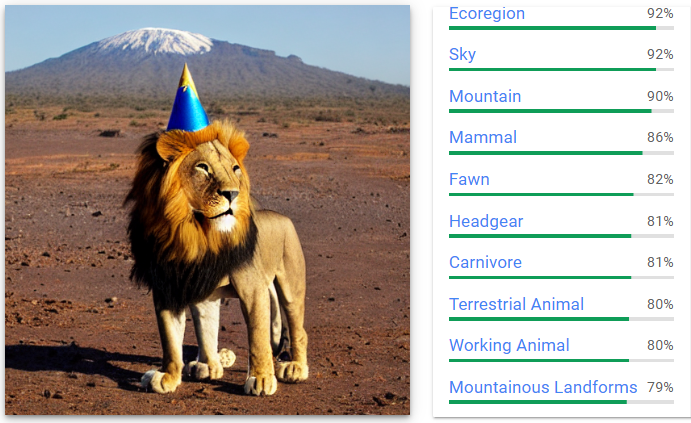

We want to run the Google Cloud Vision API on a large set of images. Beam is the ideal tool to handle this. In this notebook we will show how to retrieve image labels with this API on a small set of images.

The steps needed to implement this are shown in the notebook:
* read the images
* batch your images together to optimize your model call
* send your images to an external API to run inference
* post-process the results of your API

⚠️  beware of API quotas and the heavy load you might incur on your external API. Make sure you have set up your pipeline and API correctly for your use case.

For optimizing the calls to external API, you can confgure [PipelineOptions](https://beam.apache.org/documentation/programming-guide/#configuring-pipeline-options) to limit the parallel calls to the external remote API. Different Runners in Beam provide options to handle the parallelism, for example:
* [DirectRunner](https://beam.apache.org/documentation/runners/direct/) provides `direct_num_workers`.
* [DataflowRunner](https://beam.apache.org/documentation/runners/dataflow/) provides `max_num_workers`.

You can find details about other runners here: [Link](https://beam.apache.org/documentation/runners/capability-matrix/) 

## Installation

Install dependencies

In [ ]:
!pip install --upgrade pip
!pip install protobuf==3.19.4
!pip install apache-beam[interactive,gcp]>=2.40.0
!pip install google-cloud-vision==3.1.1
!pip install requests

# restart the runtime in order to use newly installed versions
exit() 

Authenticate with Google so that you will be able to use the Cloud Vision API.

In [ ]:
# Follow the steps to configure your GCP setup
!gcloud init --console-only

In [ ]:

!gcloud auth application-default login

## Remote inference on Google Cloud vision API

In [ ]:
from typing import List
import io
import os
import requests

from google.cloud import vision
from google.cloud.vision_v1.types import Feature
import apache_beam as beam

For this use case we have selected some images part of the [MSCoco dataset](https://cocodataset.org/#explore), as a list of image urls. This is what we will use as input for our pipeline.

In [ ]:
image_urls = [
    "http://farm3.staticflickr.com/2824/10213933686_6936eb402b_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
    "http://farm8.staticflickr.com/7003/6528937031_10e1ce0960_z.jpg",
    "http://farm6.staticflickr.com/5207/5304302785_7b5f763190_z.jpg",
    "http://farm6.staticflickr.com/5207/5304302785_7b5f763190_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
]

def read_image(image_url):
  """Read image from url and return image_url, image bytes"""
  response = requests.get(image_url)
  image_bytes = io.BytesIO(response.content).read()
  return image_url, image_bytes  

### Custom DoFn

In order to implement remote inference, we must create our own DoFn class. This class will be responsible to send a batch of images to the Cloud vision API.

The custom DoFn allows us to initialize our API, or in case of a custom model, a model can also be loaded in the `setup` function. 

The `process` function is the most interesting part. In this function we need to implement the actual model call and return its results.

⚠️ When running remote inference, you must be prepared to encounter, identify, and handle failure as gracefully as possible. We recommend using the following techniques: 

* Exponential backoff: Retrying failed remote calls with exponentially growing pauses between retries. Using exponential backoff ensures that failures don't lead to an overwhelming number of retries in quick succession. 

* Dead letter queues: Routing failed inferences to a separate PCollection without failing the whole transform. This allows you to continue execution without failing the job (batch jobs' default behavior) or retrying indefinitely (streaming jobs' default behavior). You can then run custom pipeline logic on the deadletter queue to log the failure, alert, and push the failed message to temporary storage so that it can eventually be reprocessed. 

In [ ]:
class RemoteBatchInference(beam.DoFn):
  """DoFn that accepts a batch of images as bytearray
  and sends that batch to the Cloud vision API for remote inference."""
  def setup(self):
    """Init the Google Vision API client."""
    self._client = vision.ImageAnnotatorClient()
  
  def process(self, images_batch):
    feature = Feature()
    feature.type_ = Feature.Type.LABEL_DETECTION

    # list of image_urls
    image_urls = [image_url for (image_url, image_bytes) in images_batch]

    # create a batch request for all images in the batch
    images = [vision.Image(content=image_bytes) for (image_url, image_bytes) in images_batch]
    image_requests = [vision.AnnotateImageRequest(image=image, features=[feature]) for image in images]
    batch_image_request = vision.BatchAnnotateImagesRequest(requests=image_requests)

    # send batch request to remote endpoint
    responses = self._client.batch_annotate_images(request=batch_image_request).responses
    
    return list(zip(image_urls, responses))


### Batching

Before we can chain all the different steps together in a pipeline, there is one more thing we need to understand: batching. When running inference with your model (both in Beam itself or in an external API), you can batch your input together to allow for more efficient execution of your model. When using a custom DoFn, you need to take care of the batching yourself, in contrast with the RunInference API which takes care of this for you.

In order to achieve this in our pipeline: we will introduce one more step in our pipeline, a `BatchElements` transform that will group elements together to form a batch of the desired size.

⚠️ If you have a streaming pipeline, you may considering using [GroupIntoBatches](https://beam.apache.org/documentation/transforms/python/aggregation/groupintobatches/) as `BatchElements` doesn't batch things across bundles. `GroupIntoBatches` requires choosing a key within which things are batched.

⚠️ When batching make sure that the input batch matches the max payload of the external API.  

⚠️ If you are designing your own API endpoint, then make sure that it can handle batches. 

  

### Create pipeline

Now we can chain the different steps all together to read data, transform it to fit the model input, run remote inference and finally process and display the results.

In [ ]:
with beam.Pipeline() as pipeline:
  _ = (pipeline | "Create inputs" >> beam.Create(image_urls)
                | "Read images" >> beam.Map(read_image)
                | "Batch images" >> beam.BatchElements(min_batch_size=2, max_batch_size=4)
                | "Inference" >> beam.ParDo(RemoteBatchInference())
                | "Print image_url and annotation" >> beam.Map(print)
  )

('http://farm3.staticflickr.com/2824/10213933686_6936eb402b_z.jpg', label_annotations {
  mid: "/m/083wq"
  description: "Wheel"
  score: 0.9790800213813782
  topicality: 0.9790800213813782
}
label_annotations {
  mid: "/m/0h9mv"
  description: "Tire"
  score: 0.9781236052513123
  topicality: 0.9781236052513123
}
label_annotations {
  mid: "/m/043g5f"
  description: "Fuel tank"
  score: 0.9584090113639832
  topicality: 0.9584090113639832
}
label_annotations {
  mid: "/m/05s2s"
  description: "Plant"
  score: 0.956047534942627
  topicality: 0.956047534942627
}
label_annotations {
  mid: "/m/0h8lk_j"
  description: "Automotive fuel system"
  score: 0.9403533339500427
  topicality: 0.9403533339500427
}
label_annotations {
  mid: "/m/07yv9"
  description: "Vehicle"
  score: 0.9362041354179382
  topicality: 0.9362041354179382
}
label_annotations {
  mid: "/m/02qwkrn"
  description: "Vehicle brake"
  score: 0.9050074815750122
  topicality: 0.9050074815750122
}
label_annotations {
  mid: "/m/

### Metrics

You should consider monitoring and measuring performance of a pipeline when deploying since monitoring can provide insight into the status and health of the application. See [RunInference Metrics](https://beam.apache.org/documentation/ml/runinference-metrics/) for an example of the types of metrics you may want to consider tracking.